In [1]:
import sys
sys.path.append('../../')

In [14]:
from SynRBL.rsmi_utils import load_database
golden = load_database('../../Data/Validation_set/golden_dataset/MCS/MCS_Impute.json.gz')
jaworski = load_database('../../Data/Validation_set/Jaworski/MCS/MCS_Impute.json.gz')
id_jaworski = ['Jaworski_139', 'Jaworski_221']
id_golden = ['golden_dataset_67', 'golden_dataset_373', 'golden_dataset_954', 'golden_dataset_1044', 'golden_dataset_1345', 'golden_dataset_1440', 'golden_dataset_1441', 'golden_dataset_1847']


In [15]:
golden_check = [golden[key] for key, value in enumerate(golden) if value['R-id'] in id_golden]
jaworski_check = [jaworski[key] for key, value in enumerate(jaworski) if value['R-id'] in id_jaworski]

Jaworski_221


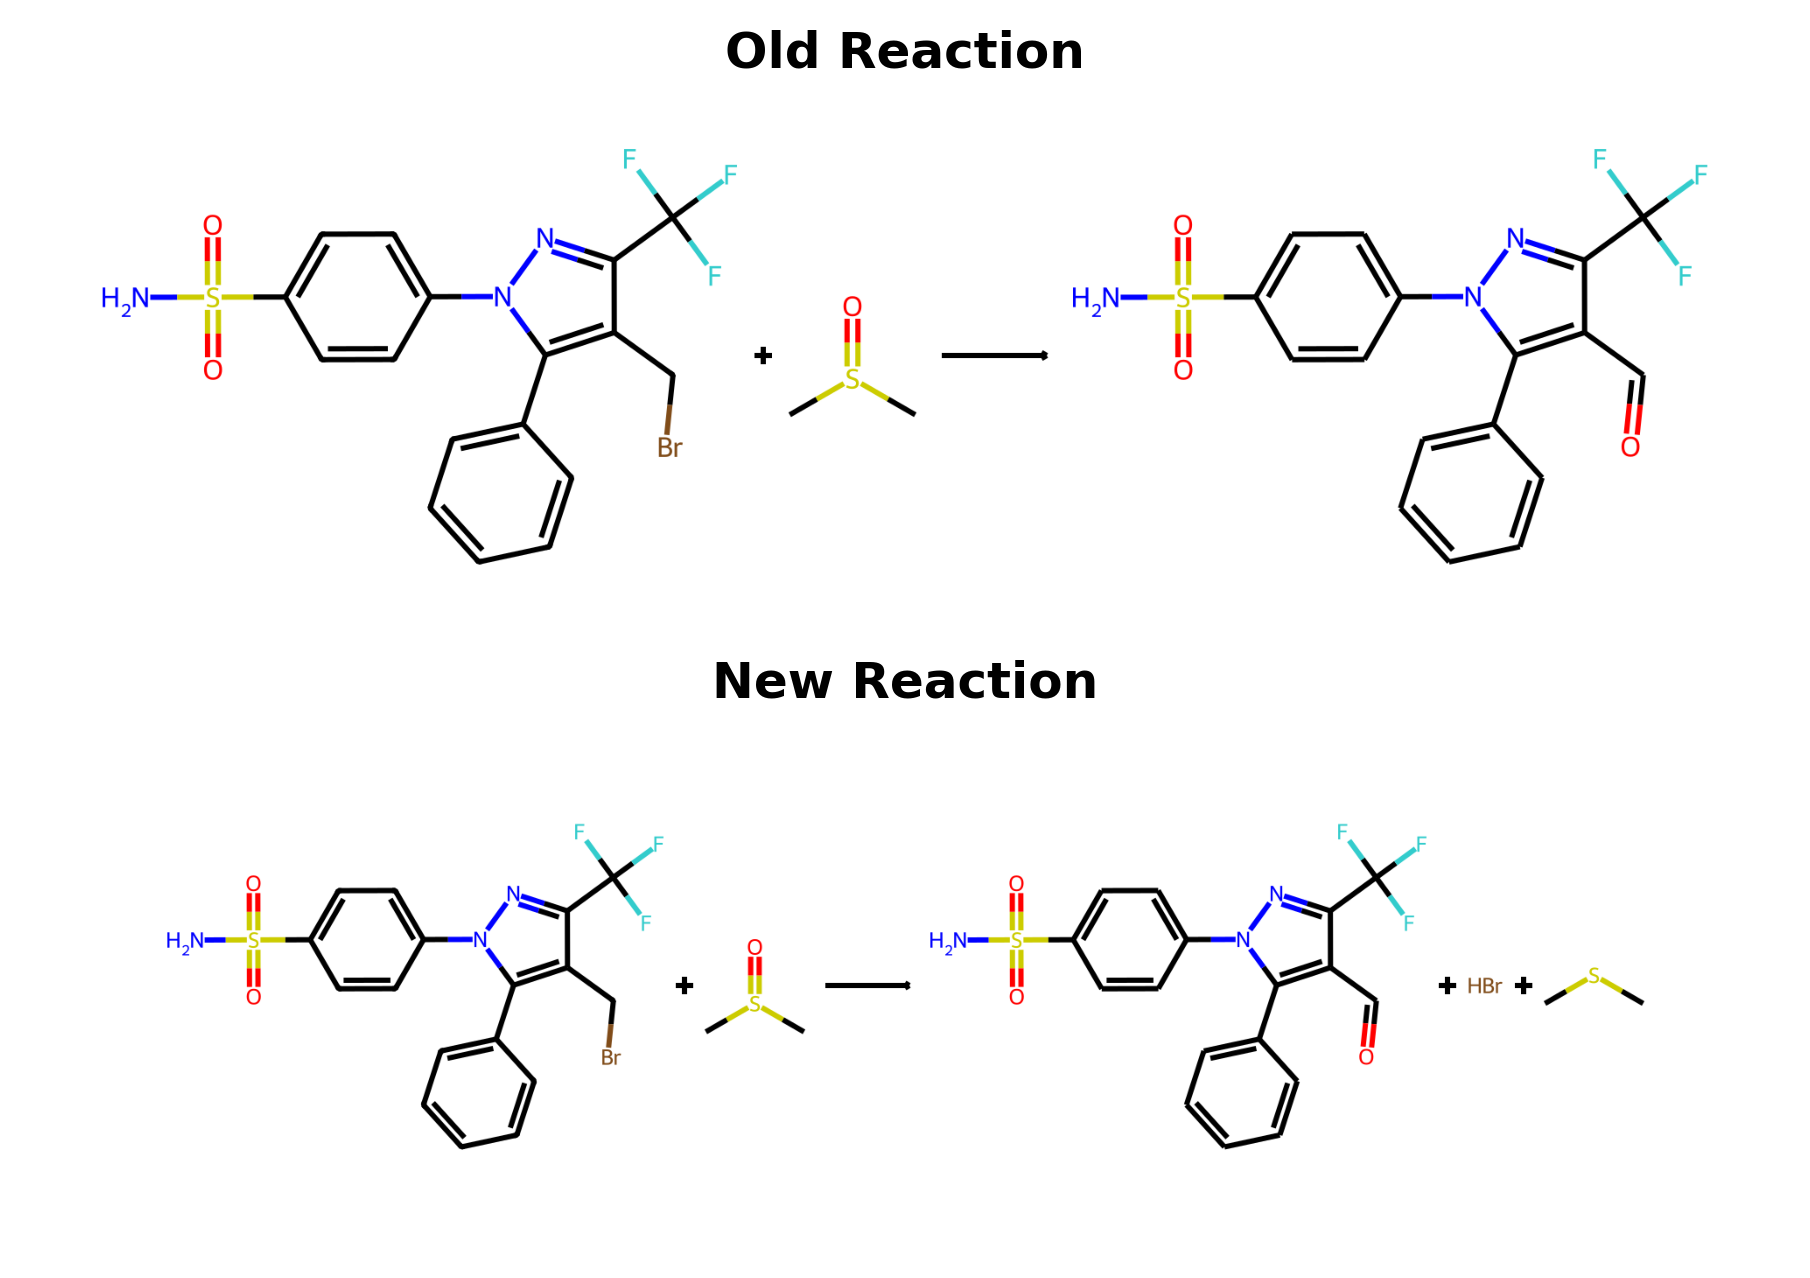

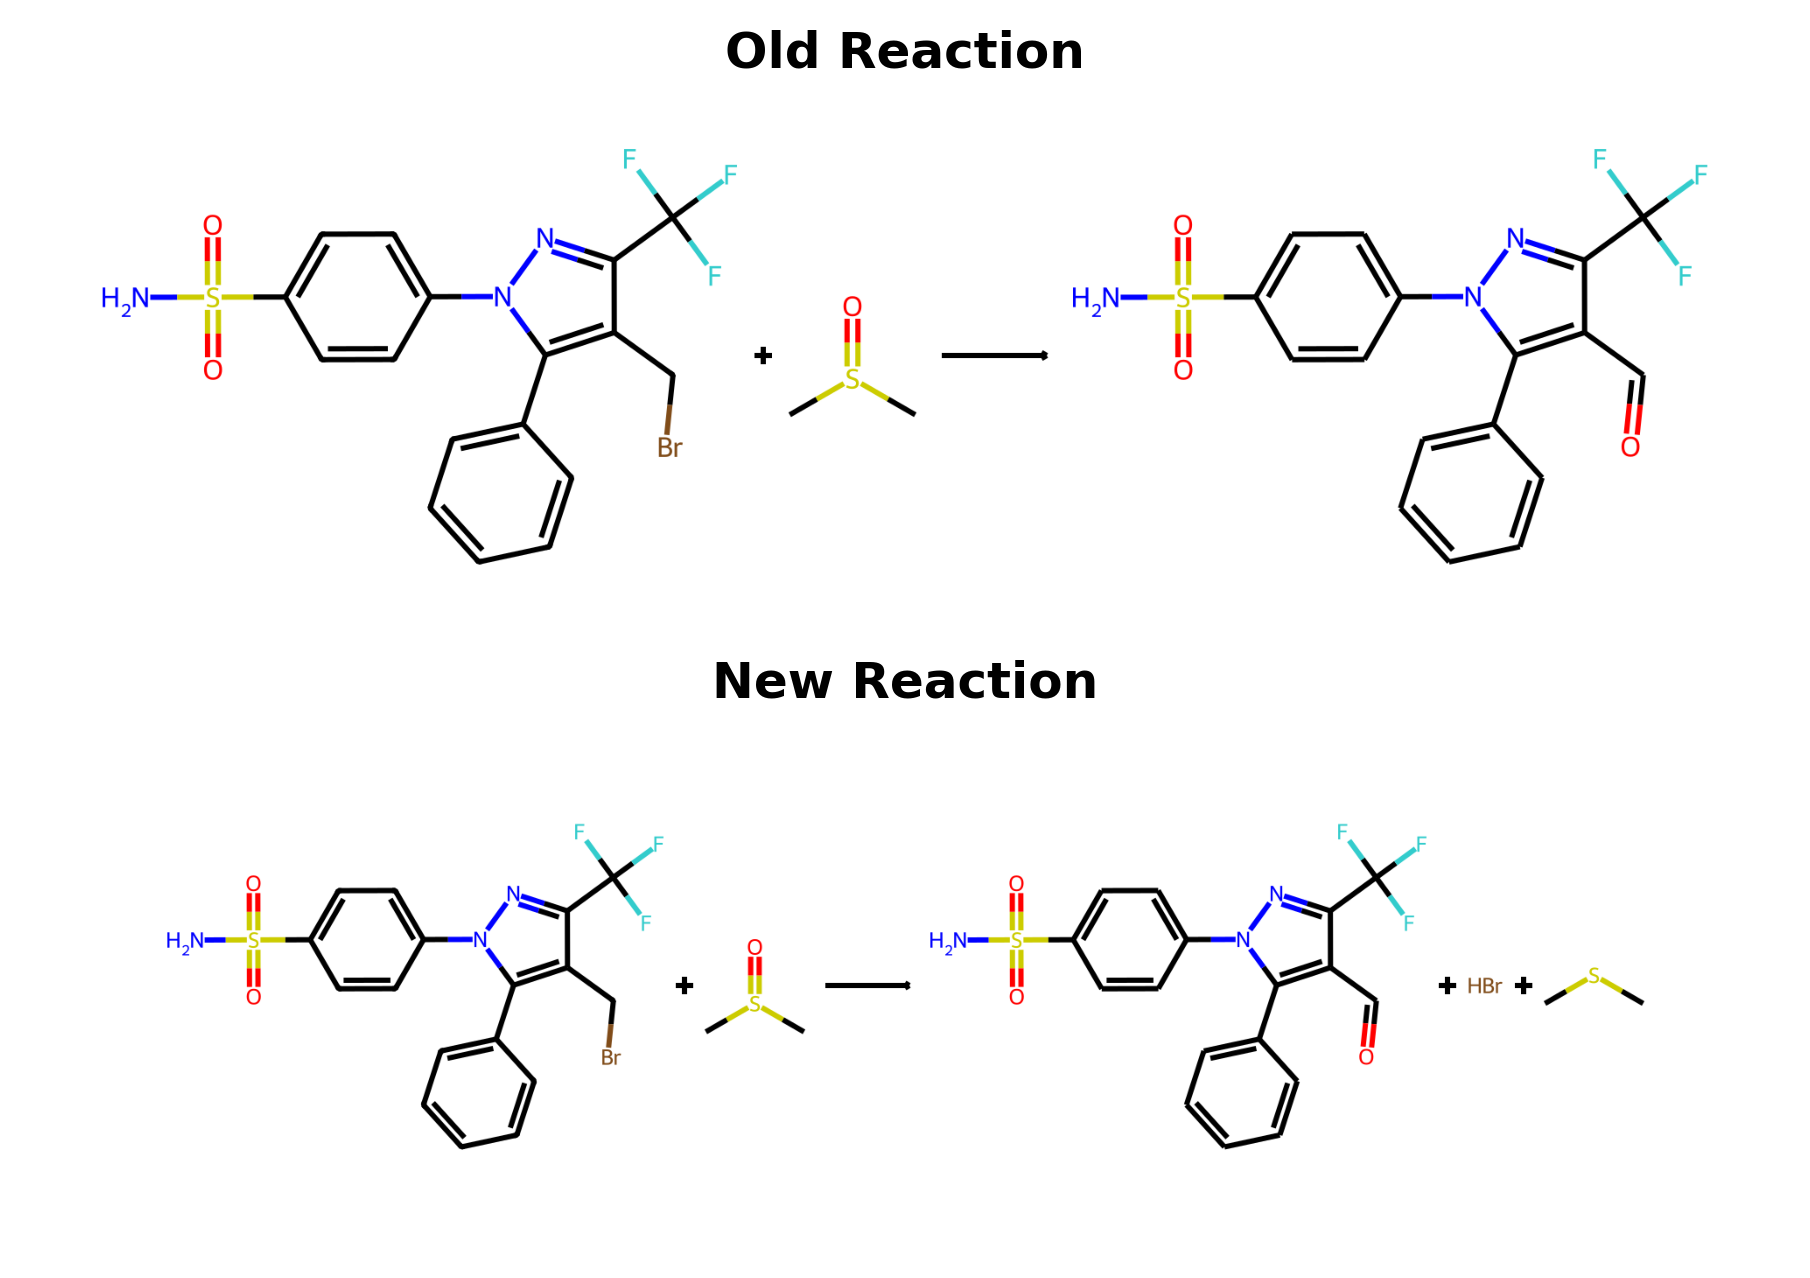

In [27]:
from SynRBL.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()
index = 1
print(jaworski_check[index]['R-id'])
vis.plot_reactions(jaworski_check[index], 'old_reaction', 'new_reaction', compare=True, show_atom_numbers=False)

In [ ]:
import pandas as pd

random_data = pd.read_csv('../../Data/Validation_set/USPTO_random_class.csv')
random_data.shape

In [ ]:
diff_data = pd.read_csv('../../Data/Validation_set/USPTO_diff.csv')
diff_data.shape

In [ ]:
unbalance_data = pd.read_csv('../../Data/Validation_set/USPTO_unbalance_class.csv')
unbalance_data.shape

In [ ]:
from SynRBL.rsmi_utils import load_database, save_database

art1 = load_database('../../Data/Validation_set/artificial_data_1/mcs_based_reactions.json.gz')
art2 = load_database('../../Data/Validation_set/artificial_data_2/mcs_based_reactions.json.gz')

In [ ]:
uspto_1 = load_database('../../Data/Validation_set/USPTO_random_class/rule_based_reactions.json.gz')

In [ ]:
uspto_1[176]

In [ ]:
import pandas as pd

test = pd.DataFrame(art1)

In [ ]:
test.shape

In [ ]:
test['reactants'].isnull().sum()

In [ ]:
jaworski = load_database('../../Data/Validation_set/Jaworski/mcs_based_reactions.json.gz')

In [ ]:
jaworski = load_database('../../Data/Validation_set/Jaworski/MCS/Condition_5.json.gz')
len(jaworski)

In [ ]:
jaworski = load_database('../../Data/Validation_set/Jaworski/MCS/Final_Graph.json.gz')

In [ ]:
len(jaworski)

In [ ]:
pd.DataFrame(jaworski).dropna()

In [ ]:
len(jaworski)

In [ ]:
golden = load_database('../../Data/Validation_set/golden_dataset/MCS/MCS_Impute.json.gz')

In [ ]:
golden_true = [golden[key] for key, value in enumerate(golden) if value['mcs_carbon_balanced']==True]
golden_false = [golden[key] for key, value in enumerate(golden) if value['mcs_carbon_balanced']==False]

In [ ]:
len(golden_false)

In [ ]:
from SynRBL.SynVis.reaction_visualizer import ReactionVisualizer
import matplotlib
vis = ReactionVisualizer()
for i in range(100,200):
    vis.plot_reactions(golden_false[i], 'old_reaction', 'new_reaction', compare=True, show_atom_numbers=False, savefig=True, pathname=f'../../Data/Validation_set/golden_dataset/check_mcs_false/{i}.png')
    matplotlib.pyplot.close()

In [ ]:
golden_false[28]

In [ ]:
rule = load_database('../../Data/Rules/rules_manager.json.gz')
rule

In [ ]:
import pandas as pd
jaworski = pd.read_csv('../../Data/Validation_set/golden_dataset.csv')

In [ ]:
uspto_1 = load_database('../../Data/Validation_set/USPTO_diff/mcs_based_reactions.json.gz')
uspto_rule_1 = load_database('../../Data/Validation_set/USPTO_diff/rule_based_reactions.json.gz')
uspto_2 = load_database('../../Data/Validation_set/USPTO_unbalance_class/mcs_based_reactions.json.gz')
uspto_rule_2 = load_database('../../Data/Validation_set/USPTO_unbalance_class/rule_based_reactions.json.gz')

In [ ]:
uspto_rule_1[0]

In [ ]:
art

In [ ]:
key_get = ['id', 'class', 'reactions']

In [ ]:
uspto_2.extend(uspto_rule_2)

In [ ]:
pd.DataFrame(uspto_2)[['id','class', 'reactions']].to_csv('../../Data/Validation_set/USPTO_unbalance_class.csv', index=False)

In [ ]:
pd.DataFrame(uspto_2)

In [ ]:
uspto_dff_1 =

In [ ]:
jaworski[jaworski.duplicated(subset=['reactions'], keep=False)]

In [ ]:
list_wrong = [11,213, 234, 221, 225, 227, 233, 239, 240, 241, 242, 249, 270, 273, 283, 366, 374, 375, 444, 449, 481, 635, 663]

In [ ]:
len(list_wrong)

In [ ]:
golden_wrong = [golden[i] for i in list_wrong]

In [ ]:
golden

In [ ]:
ground_truth

In [ ]:
ground_truth = golden.copy()

In [ ]:
import pandas as pd
ground_truth = pd.DataFrame(ground_truth)[['R-id', 'reactions']].to_dict(orient='records')

In [ ]:
ground_truth[630]['reactions'] = number_630
vis.plot_reactions(ground_truth[630], 'reactions', 'reactions', compare=False, savefig=False)

In [ ]:
# wrong reaction fix


number_444 = '[CH:17]=1[CH:18]=[CH:19][C:14](=[CH:15][CH:16]=1)[CH:12]([OH:13])[CH2:11][CH2:10][CH2:9][CH2:8][CH2:7][CH2:6][CH2:5][CH2:4][CH2:3][CH3:2].[OH-:1]>>[CH:17]=1[CH:18]=[CH:19][C:14](=[CH:15][CH:16]=1)[CH:12]([OH:13])[CH2:11][CH2:10][CH2:9][CH2:8][CH2:7][CH2:6][CH2:5][CH2:4][CH2:3][CH3:2].[OH-:1]'

number_449 = '[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][Br:6].[Mg:7]>>[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][Mg:7][Br:6]'

number_481  = '[CH:6]=1[CH:7]=[CH:8][CH:9]=[CH:10][C:5]=1[CH3:4].[O-:3][N+:2](=[O:1])[OH:11]>>[N+:2]([O-:3])(=[O:1])[C:8]1=[CH:7][CH:6]=[C:5]([CH3:4])[CH:10]=[CH:9]1.[OH:12]'


number_663 = '[CH:12]1=[C:11]([CH2:10][N:9]([CH2:17][C:18]2=[CH:19][CH:20]=[CH:21][CH:22]=[CH:23]2)[C:8]=3[CH:24]=[CH:25][CH:26]=[C:6]([CH:7]=3)[Br:29])[CH:16]=[CH:15][CH:14]=[CH:13]1.[CH2:3]1[CH2:4][CH2:5][CH:1]([CH2:2]1)[Br:27].[Mg:28]>>[CH2:2]1[CH2:3][CH2:4][CH2:5][CH:1]1[C:6]=2[CH:26]=[CH:25][CH:24]=[C:8]([CH:7]=2)[N:9]([CH2:17][C:18]=3[CH:19]=[CH:20][CH:21]=[CH:22][CH:23]=3)[CH2:10][C:11]=4[CH:16]=[CH:15][CH:14]=[CH:13][CH:12]=4.[Br:27][Mg:28][Br:29]'



In [ ]:
# wrong reaction rule based


number_621 ='[C:3](=[O:5])([CH2:2][CH3:1])[CH3:4].[NH2:8][N:7]([CH3:6])[C:9]1=[CH:10][CH:11]=[CH:12][CH:13]=[CH:14]1>>[CH:11]=1[CH:12]=[CH:13][CH:14]=[C:9]2[C:10]=1[C:2]([CH3:1])=[C:3]([CH3:4])[N:7]2[CH3:6].[NH3:8].[OH2:5]'

number_630 = '[CH2:7]([CH2:8][OH:9])[CH3:6].[Cl:1][C:2]([Cl:3])([Cl:4])[Cl:5].[CH:11]1=[CH:12][CH:13]=[CH:14][CH:15]=[C:16]1[P:10]([C:17]2=[CH:18][CH:19]=[CH:20][CH:21]=[CH:22]2)[C:23]1=[CH:24][CH:25]=[CH:26][CH:27]=[C:28]1>>[CH2:7]([CH3:6])[CH2:8][Cl:5].[Cl:1][CH:2]([Cl:3])[Cl:4].[CH:11]1=[CH:12][CH:13]=[CH:14][CH:15]=[C:16]1[P:10](=[O:5])([C:17]2=[CH:18][CH:19]=[CH:20][CH:21]=[CH:22]2)[C:23]1=[CH:24][CH:25]=[CH:26][CH:27]=[C:28]1'

In [ ]:

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdChemReactions as Reactions
from rdkit.Chem.Draw import IPythonConsole
from PIL import Image

display(Reactions.ReactionFromSmarts(number_283, useSmiles=True))

vis.plot_reactions(golden[283], 'reactions', 'new_reaction', compare=True, show_atom_numbers=False)


In [ ]:
golden[621]['reactions']

In [ ]:
from SynRBL.SynChemImputer.appel_reaction import AppelReaction

appel = AppelReaction()


In [ ]:
golden[283]['reactions']

In [ ]:
Chem.MolFromSmiles('[C-:26]#[O+:27]')

In [ ]:
test ='[C-:26]#[O+:27].[CH3:19][C:18]([CH3:20])([CH3:21])[Si:15]([CH3:16])([CH3:17])[O:14][CH2:13][CH2:12][CH:11]1[CH:10]2[CH:1]([CH:25]=[CH:24][CH:22]1[OH:23])[CH2:2][CH2:3][N:4]2[C:5](=[O:6])[O:7][CH2:8][CH3:9].[NH3:27]>>[CH3:19][C:18]([CH3:20])([CH3:21])[Si:15]([CH3:16])([CH3:17])[O:14][CH2:13][CH2:12][CH:11]1[CH:22]=[CH:24][CH:25]([CH:1]2[CH2:2][CH2:3][N:4]([C:5](=[O:6])[O:7][CH2:8][CH3:9])[CH:10]12)[C:26](=[O:27])[NH2:27].[OH2:23]'

In [ ]:
vis.plot_reactions(golden[283], 'reactions', 'new_reaction', compare=True, show_atom_numbers=False)

In [ ]:
save_database(ground_truth, '../../Data/Validation_set/golden_dataset/rule_based_ground_truth.json.gz')

In [ ]:
golden[630]['reactions']

In [ ]:
c1ccccc1P(c2ccccc2)c3ccccc3

In [ ]:
from SynRBL.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()
vis.plot_reactions(golden[630], 'reactions', 'new_reaction', compare=True, show_atom_numbers=False)

In [ ]:
vis.plot_reactions(golden_wrong[16], 'reactions', 'new_reaction', compare=True, show_atom_numbers=False)

In [ ]:
# Jaworski class
jaworski = load_database('../../Data/Validation_set/Jaworski/rule_based_reactions.json.gz')
jaworski_167 = 'BrBr.CC1=C(C(OC)=O)C=CC=C1[N+]([O-])=O>>O=C(OC)C2=C(CBr)C([N+]([O-])=O)=CC=C2.Br'
jaworski_171 = 'CC1(O[C@@H]2COC([C@@H]2O1)O)C.Br[Mg]C=C.O>>CC1(O[C@@H]([C@H]([C@H](C=C)O)O1)CO)C.Br[Mg+][OH]'

In [ ]:
display(Reactions.ReactionFromSmarts(jaworski_171, useSmiles=True))

In [ ]:
import pandas as pd
ground_truth = jaworski.copy()
ground_truth = pd.DataFrame(ground_truth)[['R-id', 'reactions']].to_dict(orient='records')

In [ ]:
save_database(ground_truth, '../../Data/Validation_set/Jaworski/rule_based_ground_truth.json.gz')

In [ ]:
ground_truth[167]['reactions'] = jaworski_167
ground_truth[171]['reactions'] = jaworski_171

In [ ]:
ground_truth[167]

/tmp/ipykernel_103434/1793427884.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


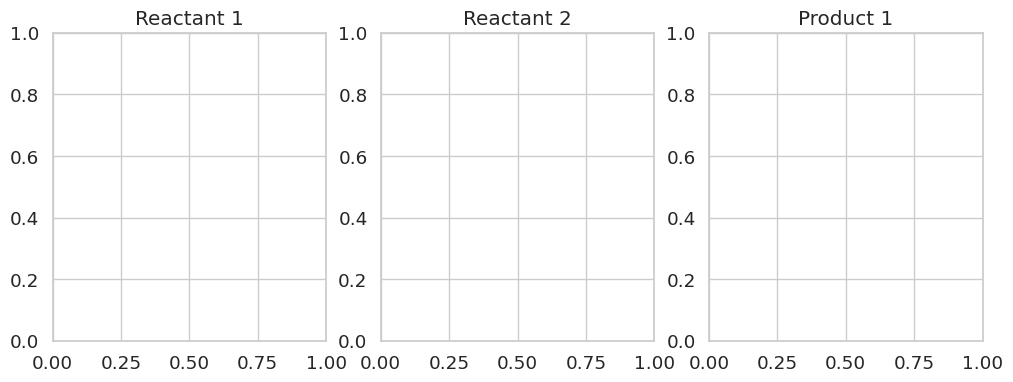

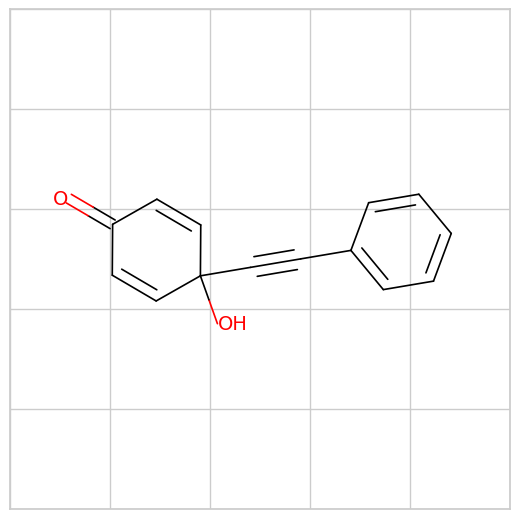

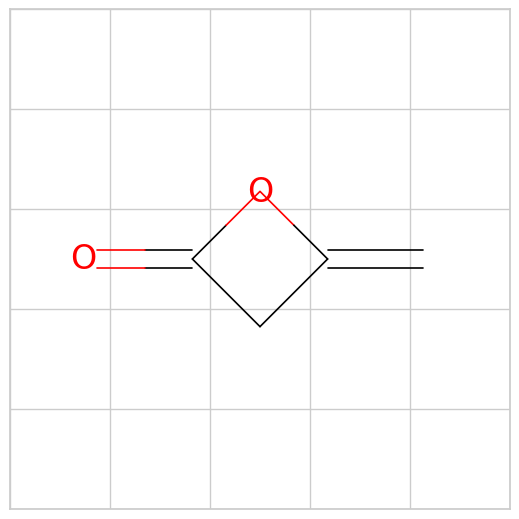

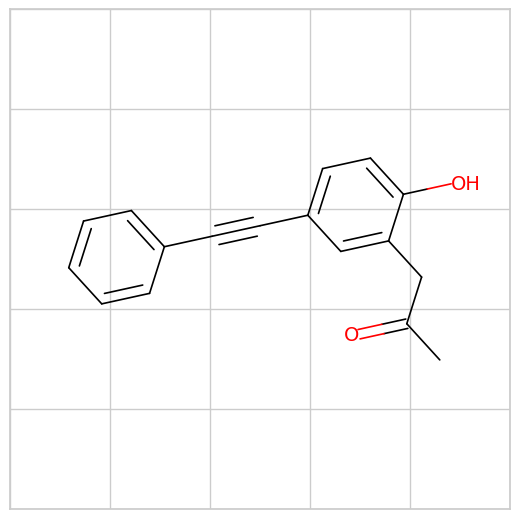

In [248]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

class ChemicalSpaceVisualizer:
    def __init__(self, reaction_smiles):
        self.reaction_smiles = reaction_smiles

    def visualize_reactants_and_products(self):
        # Parse the reaction SMILES string
        reaction = AllChem.ReactionFromSmarts(self.reaction_smiles)

        # Extract reactants and products
        reactants = reaction.GetReactants()
        products = reaction.GetProducts()

        # Generate 2D chemical structure diagrams for reactants and products
        reactant_mols = [Chem.MolFromSmiles(Chem.MolToSmiles(reactant)) for reactant in reactants]
        product_mols = [Chem.MolFromSmiles(Chem.MolToSmiles(product)) for product in products]

        # Create subplots for reactants and products
        num_reactants = len(reactants)
        num_products = len(products)
        num_subplots = num_reactants + num_products

        fig, axes = plt.subplots(1, num_subplots, figsize=(12, 4))

        for i, mol in enumerate(reactant_mols):
            Draw.MolToMPL(mol, ax=axes[i], size=(200, 200))
            axes[i].set_title(f"Reactant {i+1}")

        for i, mol in enumerate(product_mols):
            Draw.MolToMPL(mol, ax=axes[i+num_reactants], size=(200, 200))
            axes[i+num_reactants].set_title(f"Product {i+1}")

        plt.tight_layout()
        plt.show()

# Example usage:
reaction_smiles = "OC1(C=CC(=O)C=C1)C#Cc1ccccc1.C=C1CC(=O)O1>>CC(=O)Cc1cc(ccc1O)C#Cc1ccccc1"
visualizer = ChemicalSpaceVisualizer(reaction_smiles)
visualizer.visualize_reactants_and_products()


In [ ]:
from SynRBL.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()
vis.plot_reactions(ground_truth[171], 'reactions', 'reactions', compare=False, show_atom_numbers=False)

In [246]:
raw_mcs

[{'reactions': 'OC1(C=CC(=O)C=C1)C#Cc1ccccc1.C=C1CC(=O)O1>>CC(=O)Cc1cc(ccc1O)C#Cc1ccccc1',
  'id': 'complex_8',
  'reactants': 'OC1(C=CC(=O)C=C1)C#Cc1ccccc1.C=C1CC(=O)O1',
  'products': 'CC(=O)Cc1cc(ccc1O)C#Cc1ccccc1',
  'R-id': 'Jaworski_8',
  'carbon_balance_check': 'products'},
 {'reactions': 'O=Cc1ccccc1.C[Si](C)(C)CC=C>>OC(CC=C)c1ccccc1',
  'id': 'complex_14',
  'reactants': 'O=Cc1ccccc1.C[Si](C)(C)CC=C',
  'products': 'OC(CC=C)c1ccccc1',
  'R-id': 'Jaworski_14',
  'carbon_balance_check': 'products'},
 {'reactions': '[H][C@]12CCN(C(=O)OCC)[C@]1([H])[C@H](CCO[Si](C)(C)C(C)(C)C)[C@H](O)C=C2>>[H][C@]12CCN(C(=O)OCC)[C@]1([H])[C@H](CCO[Si](C)(C)C(C)(C)C)C=C[C@@H]2C(N)=O',
  'id': 'complex_31',
  'reactants': '[H][C@]12CCN(C(=O)OCC)[C@]1([H])[C@H](CCO[Si](C)(C)C(C)(C)C)[C@H](O)C=C2',
  'products': '[H][C@]12CCN(C(=O)OCC)[C@]1([H])[C@H](CCO[Si](C)(C)C(C)(C)C)C=C[C@@H]2C(N)=O',
  'R-id': 'Jaworski_31',
  'carbon_balance_check': 'reactants'},
 {'reactions': 'CO[C@@H]1C[C@@H]2OC(=O)CC2C(=C)

TEST

In [188]:
import pandas as pd
from SynRBL.rsmi_utils import load_database
jaworski = pd.read_csv('../../Data/Validation_set/Visualize/SynRBL - Jaworsky.csv')
jaworski=jaworski.iloc[:154, 1:4]
result = load_database('../../Data/Validation_set/Jaworski/MCS/MCS_Impute.json.gz')
raw_mcs = load_database('../../Data/Validation_set/Jaworski/mcs_based_reactions.json.gz')

In [189]:
jaworski.fillna(0, inplace=True)
jaworski['BondChanges'] = jaworski[['Bond Break', 'Bond Form']].max(axis=1)
jaworski = jaworski.drop(['Bond Break', 'Bond Form'], axis=1)

In [190]:
from rdkit import Chem
from copy import deepcopy

def calculate_carbon_difference(dictionary_list):
    updated_list = deepcopy(dictionary_list)  # Create a deep copy of the original list
    for entry in updated_list:
        reactant_smiles = entry['reactants']
        product_smiles = entry['products']
        
        reactant_mol = Chem.MolFromSmiles(reactant_smiles)
        product_mol = Chem.MolFromSmiles(product_smiles)
        
        if reactant_mol is not None and product_mol is not None:
            num_carbon_reactants = reactant_mol.GetNumAtoms(6)
            num_carbon_products = product_mol.GetNumAtoms(6)
            
            delta = abs(num_carbon_reactants - num_carbon_products)
            entry['carbon_difference'] = delta
        else:
            entry['carbon_difference'] = "Invalid SMILES"
    return updated_list

new_raw = calculate_carbon_difference(raw_mcs)

[13:41:08] WARNING: the onlyHeavy argument to mol.GetNumAtoms() has been deprecated. Please use the onlyExplicit argument instead or mol.GetNumHeavyAtoms() if you want the heavy atom count.
[13:41:08] WARNING: the onlyHeavy argument to mol.GetNumAtoms() has been deprecated. Please use the onlyExplicit argument instead or mol.GetNumHeavyAtoms() if you want the heavy atom count.
[13:41:08] WARNING: the onlyHeavy argument to mol.GetNumAtoms() has been deprecated. Please use the onlyExplicit argument instead or mol.GetNumHeavyAtoms() if you want the heavy atom count.
[13:41:08] WARNING: the onlyHeavy argument to mol.GetNumAtoms() has been deprecated. Please use the onlyExplicit argument instead or mol.GetNumHeavyAtoms() if you want the heavy atom count.
[13:41:08] WARNING: the onlyHeavy argument to mol.GetNumAtoms() has been deprecated. Please use the onlyExplicit argument instead or mol.GetNumHeavyAtoms() if you want the heavy atom count.
[13:41:08] WARNING: the onlyHeavy argument to mol.

In [195]:
def calculate_fragment_count(dictionary_list):
    updated_list = deepcopy(dictionary_list) 
    for entry in dictionary_list:
        reactant_smiles = entry['reactants']
        product_smiles = entry['products']

        # Counting the number of fragments in reactants and products
        reactant_fragment_count = len(reactant_smiles.split('.'))
        product_fragment_count = len(product_smiles.split('.'))
        total_fragment_count = reactant_fragment_count + product_fragment_count
        entry['fragment_count'] = total_fragment_count
        #print(total_fragment_count)
    return updated_list


In [196]:
new_raw2 = calculate_fragment_count(new_raw)

In [197]:
new_raw2[0]

{'reactions': 'OC1(C=CC(=O)C=C1)C#Cc1ccccc1.C=C1CC(=O)O1>>CC(=O)Cc1cc(ccc1O)C#Cc1ccccc1',
 'id': 'complex_8',
 'reactants': 'OC1(C=CC(=O)C=C1)C#Cc1ccccc1.C=C1CC(=O)O1',
 'products': 'CC(=O)Cc1cc(ccc1O)C#Cc1ccccc1',
 'R-id': 'Jaworski_8',
 'carbon_balance_check': 'products',
 'carbon_difference': 3,
 'fragment_count': 3}

In [198]:
test1=pd.concat([pd.DataFrame(new_raw2)[['R-id','carbon_difference', 'fragment_count']],jaworski, pd.DataFrame(result)[['mcs_carbon_balanced']]], axis=1)

In [199]:
test1['Result'] =test1['Result'].astype('bool')

In [200]:
test2 = test1[test1['mcs_carbon_balanced']==True]

In [201]:
test2['Result'].sum()

123

/tmp/ipykernel_103434/1639920897.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=data, x=x, y=y, palette=palette)
/tmp/ipykernel_103434/1639920897.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=data, x=x, y=y, palette=palette)
/tmp/ipykernel_103434/1639920897.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=data, x=x, y=y, palette=palette)


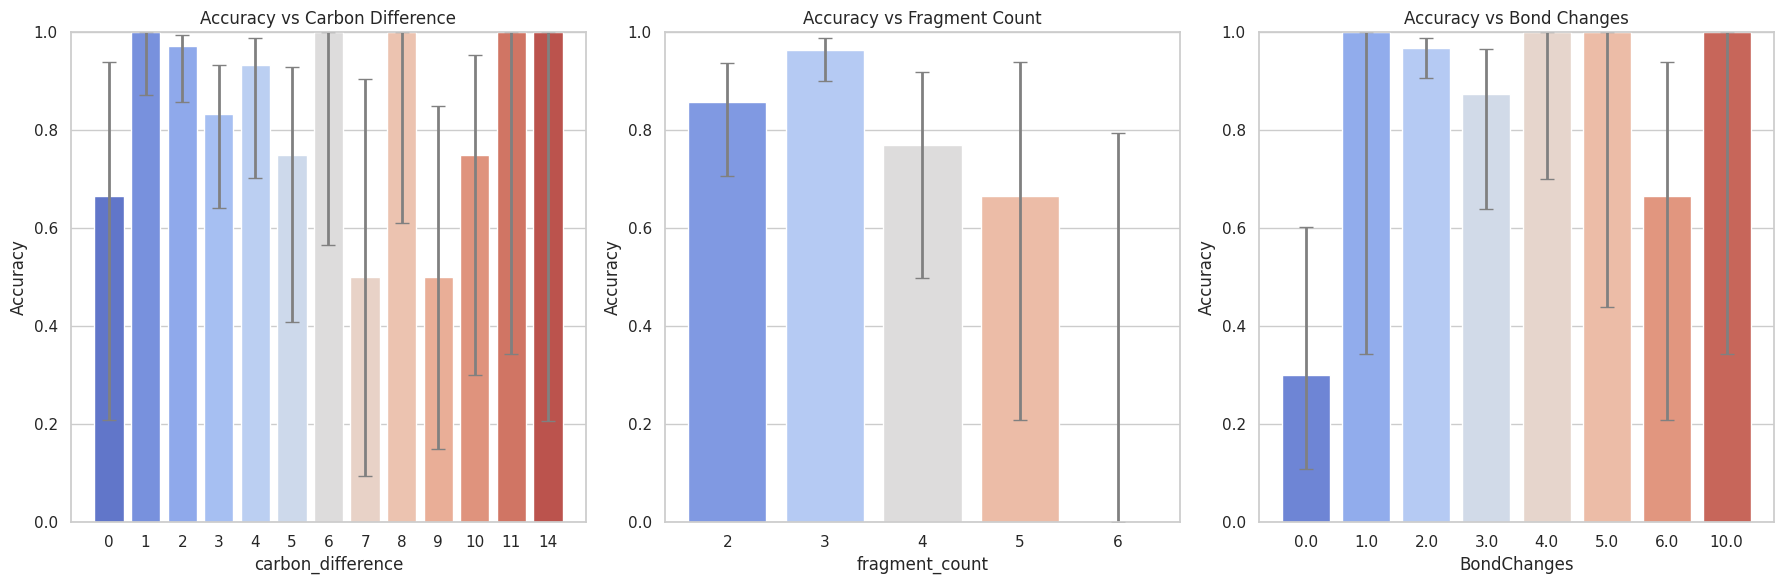

In [205]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint

def visualize_accuracy(df, error_bar=True, chart_type='line', bar_color_palette='pastel', error_bar_color='black'):
    def calculate_accuracy_and_confidence(df, column):
        group_data = df.groupby(column)['Result'].agg(['sum', 'size'])
        group_data['Accuracy'] = group_data['sum'] / group_data['size']
        
        # Calculating Wilson confidence interval
        if error_bar:
            confidence_lower, confidence_upper = proportion_confint(group_data['sum'], group_data['size'], method='wilson')
            group_data['lower'] = group_data['Accuracy'] - confidence_lower
            group_data['upper'] = confidence_upper - group_data['Accuracy']

        return group_data.reset_index()

    # Calculate accuracy and confidence for each property
    accuracy_carbon = calculate_accuracy_and_confidence(df, 'carbon_difference')
    accuracy_fragment = calculate_accuracy_and_confidence(df, 'fragment_count')
    accuracy_bondchanges = calculate_accuracy_and_confidence(df, 'BondChanges')

    # Increase font size for better legibility
    sns.set_context("talk")

    # Plotting
    sns.set(style="whitegrid")
    plt.figure(figsize=(18, 6))

    # Plot helper function
    def plot_data(data, x, y, lower, upper, subplot_index, title, palette, ecolor):
        ax = plt.subplot(1, 3, subplot_index)

        if chart_type == 'line':
            if error_bar:
                # Use absolute values for error bars
                plt.errorbar(data[x], data[y], yerr=[abs(data[lower]), abs(data[upper])], fmt='o', capsize=5, ecolor=ecolor)
            sns.lineplot(data=data, x=x, y=y, marker='o')
        elif chart_type == 'bar':
            barplot = sns.barplot(data=data, x=x, y=y, palette=palette)
            ax.set_ylim(0, 1)  # Set the y-axis limit to show the full range of accuracy
            if error_bar:
                # Calculate the x position for each bar
                x_positions = [p.get_x() + p.get_width() / 2 for p in barplot.patches]
                # Use absolute values for error bars
                plt.errorbar(x_positions, data[y], yerr=[abs(data[lower]), abs(data[upper])], fmt='none', ecolor=ecolor, capsize=5, elinewidth=2)

        plt.title(title)
        plt.xlabel(x)
        plt.ylabel('Accuracy')
        # Customize the legend if necessary

    # Carbon Difference Accuracy
    plot_data(accuracy_carbon, 'carbon_difference', 'Accuracy', 'lower', 'upper', 1, 'Accuracy vs Carbon Difference', bar_color_palette, error_bar_color)

    # Fragment Count Accuracy
    plot_data(accuracy_fragment, 'fragment_count', 'Accuracy', 'lower', 'upper', 2, 'Accuracy vs Fragment Count', bar_color_palette, error_bar_color)

    # Bond Changes Accuracy
    plot_data(accuracy_bondchanges, 'BondChanges', 'Accuracy', 'lower', 'upper', 3, 'Accuracy vs Bond Changes', bar_color_palette, error_bar_color)

    plt.tight_layout()
    plt.show()

# Usage example
visualize_accuracy(test2, error_bar=True, chart_type='bar', bar_color_palette='coolwarm', error_bar_color='gray')


/tmp/ipykernel_103434/3812254199.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')
/tmp/ipykernel_103434/3812254199.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=data, x=x, y=y, palette=colors, ax=ax)
/tmp/ipykernel_103434/3812254199.py:50: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  barplot = sns.barplot(data=data, x=x, y=y, palette=colors, ax=ax)
/tmp/ipykernel_103434/3812254199.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable 

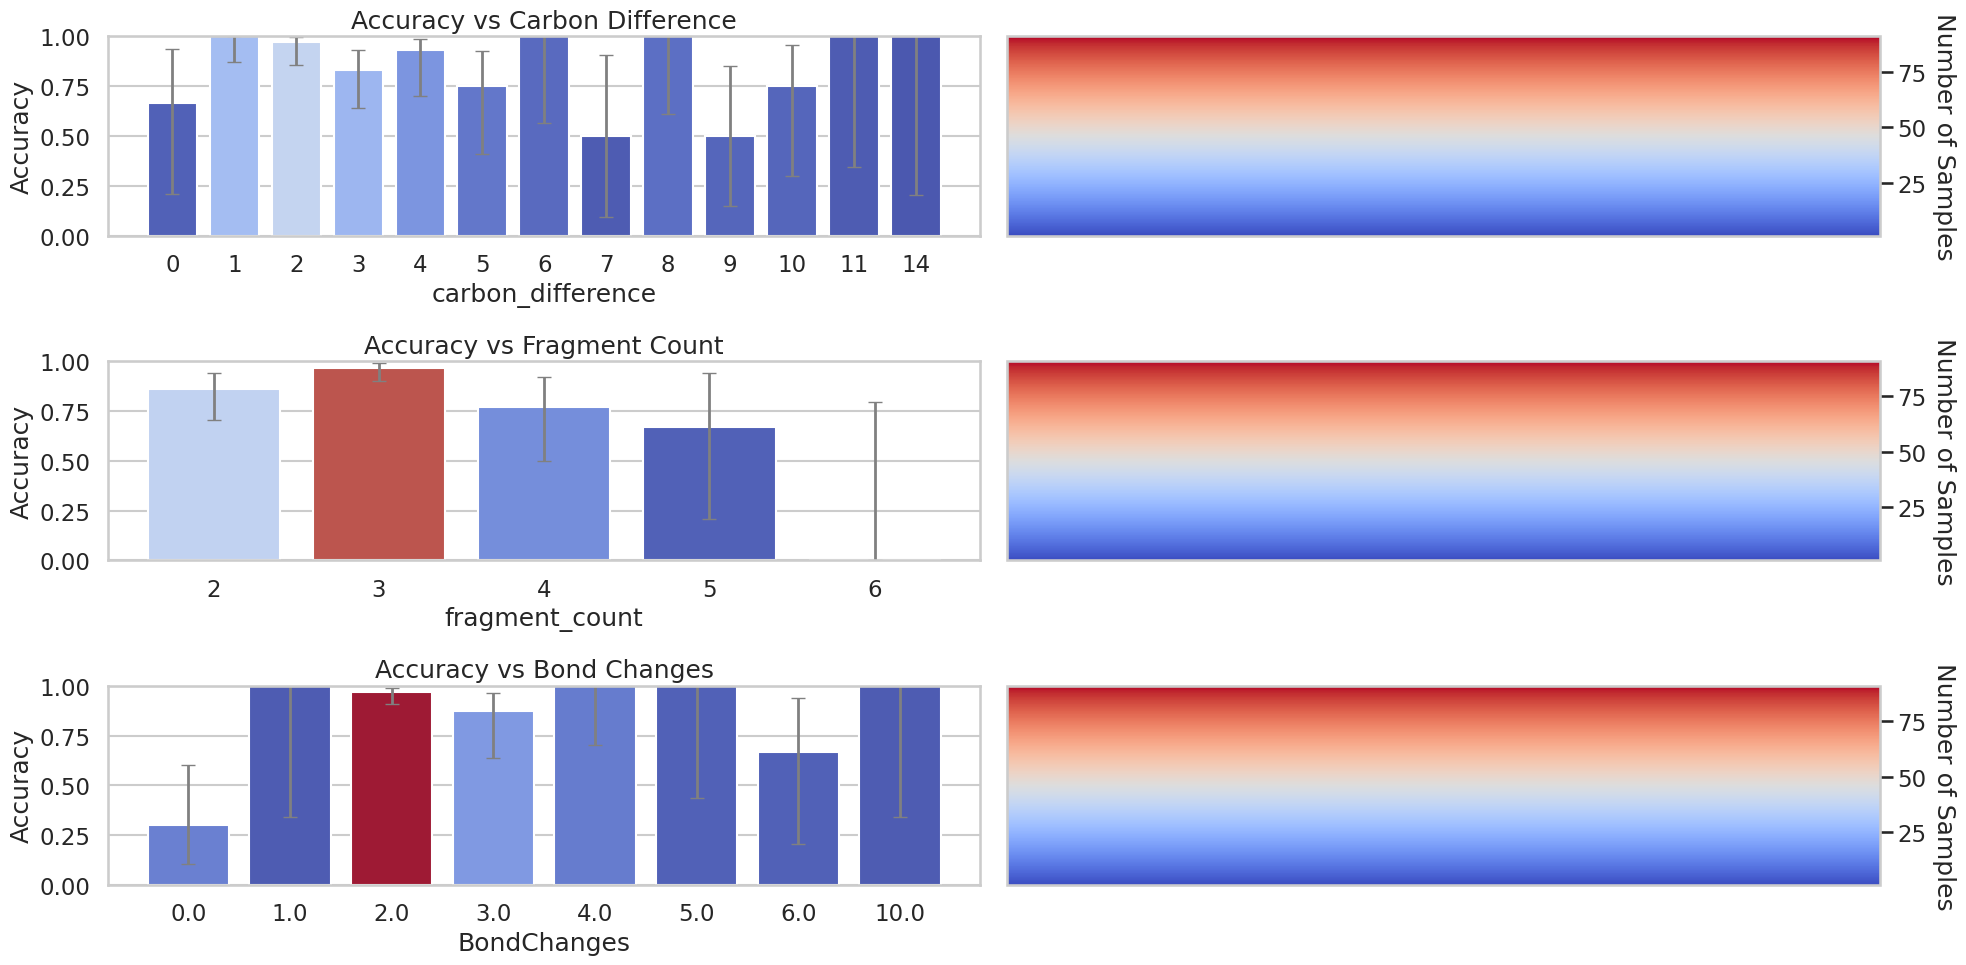

In [218]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint

def visualize_accuracy(df, error_bar=True, chart_type='line', error_bar_color='black'):
    def calculate_accuracy_and_confidence(df, column):
        group_data = df.groupby(column)['Result'].agg(['sum', 'size'])
        group_data['Accuracy'] = group_data['sum'] / group_data['size']
        
        # Calculating Wilson confidence interval
        if error_bar:
            confidence_lower, confidence_upper = proportion_confint(group_data['sum'], group_data['size'], method='wilson')
            group_data['lower'] = group_data['Accuracy'] - confidence_lower
            group_data['upper'] = confidence_upper - group_data['Accuracy']

        return group_data.reset_index()

    # Calculate accuracy and confidence for each property
    accuracy_carbon = calculate_accuracy_and_confidence(df, 'carbon_difference')
    accuracy_fragment = calculate_accuracy_and_confidence(df, 'fragment_count')
    accuracy_bondchanges = calculate_accuracy_and_confidence(df, 'BondChanges')

    # Determine the min and max values for 'size' across all three subplots
    min_size = min(accuracy_carbon['size'].min(), accuracy_fragment['size'].min(), accuracy_bondchanges['size'].min())
    max_size = max(accuracy_carbon['size'].max(), accuracy_fragment['size'].max(), accuracy_bondchanges['size'].max())

    # Create a shared color normalization for the colorbar
    norm = plt.Normalize(vmin=min_size, vmax=max_size)
    cmap = plt.cm.get_cmap('coolwarm')

    # Increase font size for better legibility
    sns.set_context("talk")

    # Create a figure with 2 columns and 3 rows
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))

    # Plot helper function
    def plot_data(data, x, y, lower, upper, size, subplot_index, title, ecolor):
        ax = axes[subplot_index, 0]

        if chart_type == 'line':
            if error_bar:
                # Use absolute values for error bars
                ax.errorbar(data[x], data[y], yerr=[abs(data[lower]), abs(data[upper])], fmt='o', capsize=5, ecolor=ecolor)
            sns.lineplot(data=data, x=x, y=y, marker='o', ax=ax)
        elif chart_type == 'bar':
            # Create a custom color palette based on the number of samples (size)
            colors = cmap(norm(data[size]))
            barplot = sns.barplot(data=data, x=x, y=y, palette=colors, ax=ax)
            ax.set_ylim(0, 1)  # Set the y-axis limit to show the full range of accuracy
            if error_bar:
                # Calculate the x position for each bar
                x_positions = [p.get_x() + p.get_width() / 2 for p in barplot.patches]
                # Use absolute values for error bars
                ax.errorbar(x_positions, data[y], yerr=[abs(data[lower]), abs(data[upper])], fmt='none', ecolor=ecolor, capsize=5, elinewidth=2)
            
            # Add a colorbar to display the number of samples (using the shared color normalization)
            cax = axes[subplot_index, 1]
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])  # This line is necessary for the colorbar to work
            cbar = plt.colorbar(sm, cax=cax, label='Number of Samples')
            cbar.ax.set_ylabel('Number of Samples', rotation=-90, va="bottom")

        ax.set_title(title)
        ax.set_xlabel(x)
        ax.set_ylabel('Accuracy')
        # Customize the legend if necessary

    # Carbon Difference Accuracy
    plot_data(accuracy_carbon, 'carbon_difference', 'Accuracy', 'lower', 'upper', 'size', 0, 'Accuracy vs Carbon Difference', error_bar_color)

    # Fragment Count Accuracy
    plot_data(accuracy_fragment, 'fragment_count', 'Accuracy', 'lower', 'upper', 'size', 1, 'Accuracy vs Fragment Count', error_bar_color)

    # Bond Changes Accuracy
    plot_data(accuracy_bondchanges, 'BondChanges', 'Accuracy', 'lower', 'upper', 'size', 2, 'Accuracy vs Bond Changes', error_bar_color)

    plt.tight_layout()
    plt.show()

# Usage example
visualize_accuracy(test2, error_bar=True, chart_type='bar', error_bar_color='gray')


/tmp/ipykernel_103434/1577228754.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=x, y=y, palette=colors, ax=ax)
/tmp/ipykernel_103434/1577228754.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=x, y=y, palette=colors, ax=ax)
/tmp/ipykernel_103434/1577228754.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=x, y=y, palette=colors, ax=ax)


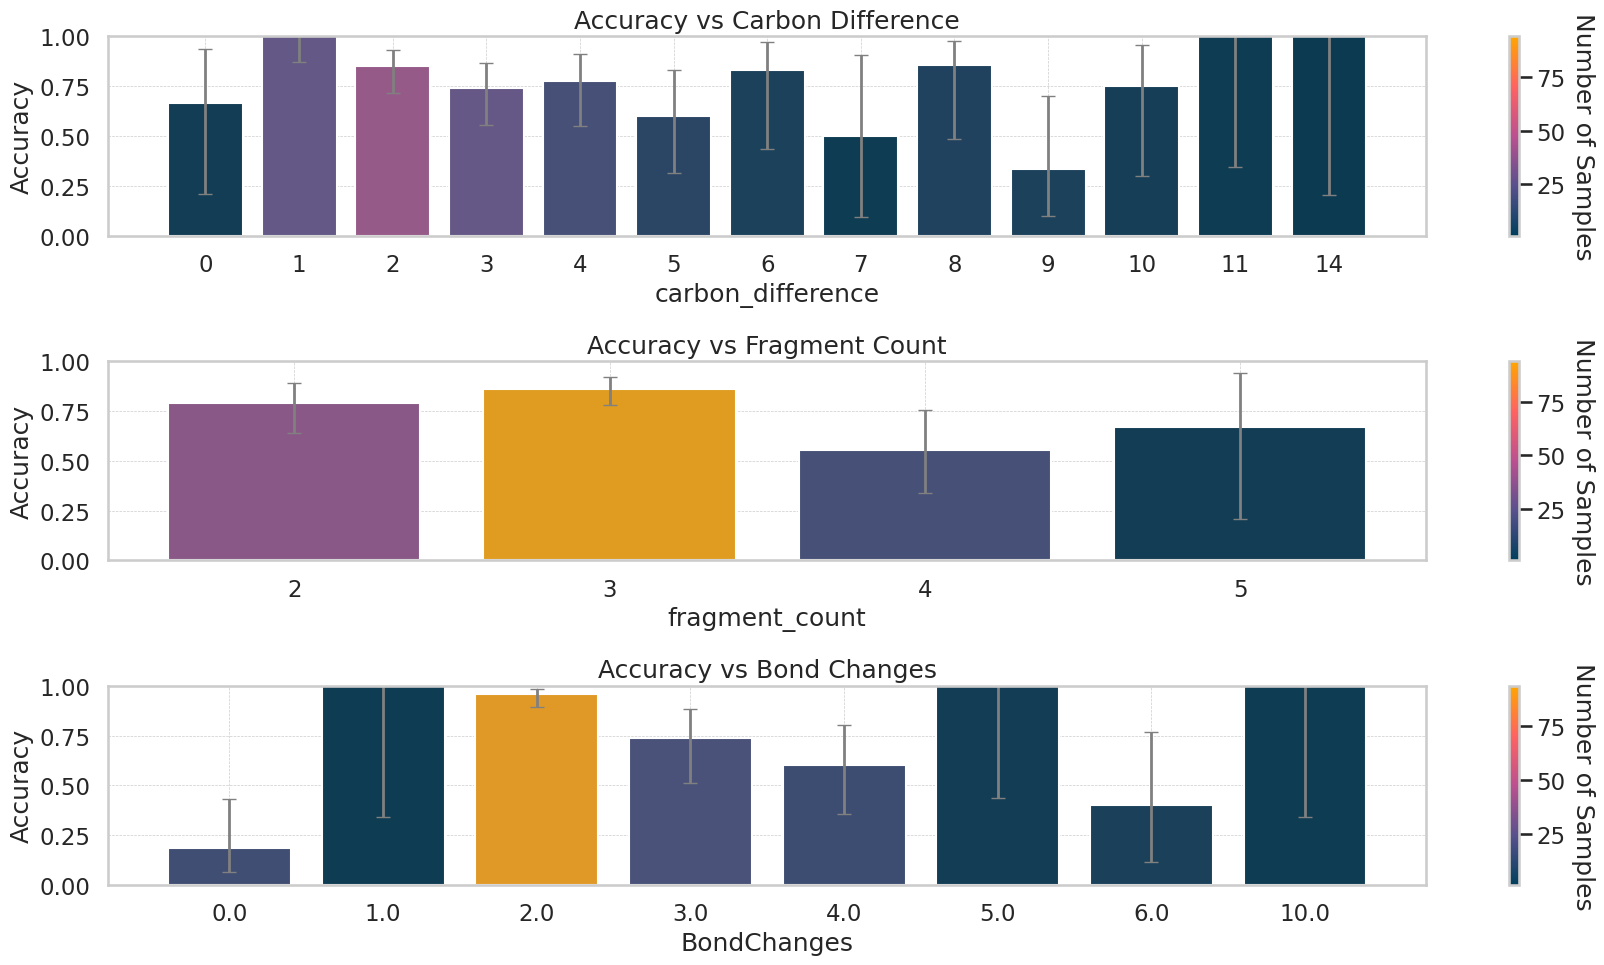

In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

def visualize_accuracy(df, error_bar=True, chart_type='line', error_bar_color='black', same_color_scale=False):
    def calculate_accuracy_and_confidence(df, column):
        group_data = df.groupby(column)['Result'].agg(['sum', 'size'])
        group_data['Accuracy'] = group_data['sum'] / group_data['size']
        
        # Filter out groups with zero accuracy
        group_data = group_data[group_data['Accuracy'] > 0]

        # Calculating Wilson confidence interval
        if error_bar:
            confidence_lower, confidence_upper = proportion_confint(group_data['sum'], group_data['size'], method='wilson')
            group_data['lower'] = group_data['Accuracy'] - confidence_lower
            group_data['upper'] = confidence_upper - group_data['Accuracy']

        return group_data.reset_index()

    # Custom color map with shades of blue and purple
    colors = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600']
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

    # Calculate accuracy and confidence for each property
    accuracy_carbon = calculate_accuracy_and_confidence(df, 'carbon_difference')
    accuracy_fragment = calculate_accuracy_and_confidence(df, 'fragment_count')
    accuracy_bondchanges = calculate_accuracy_and_confidence(df, 'BondChanges')

    # Normalization for colors
    if same_color_scale:
        norm = plt.Normalize(vmin=min(accuracy_carbon['size'].min(), accuracy_fragment['size'].min(), accuracy_bondchanges['size'].min()), 
                             vmax=max(accuracy_carbon['size'].max(), accuracy_fragment['size'].max(), accuracy_bondchanges['size'].max()))
    else:
        norm_carbon = plt.Normalize(vmin=accuracy_carbon['size'].min(), vmax=accuracy_carbon['size'].max())
        norm_fragment = plt.Normalize(vmin=accuracy_fragment['size'].min(), vmax=accuracy_fragment['size'].max())
        norm_bondchanges = plt.Normalize(vmin=accuracy_bondchanges['size'].min(), vmax=accuracy_bondchanges['size'].max())

    # Increase font size for better legibility
    sns.set_context("talk")

    # Create a figure with 3 subplots
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 10))

    # Plot helper function
    def plot_data(data, x, y, lower, upper, size, subplot_index, title, ecolor, norm):
        ax = axes[subplot_index]
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # Set an empty array for the mappable

        colors = [mcolors.to_rgba(cmap(norm(s))) for s in data[size]]

        if chart_type == 'line':
            if error_bar:
                ax.errorbar(data[x], data[y], yerr=[abs(data[lower]), abs(data[upper])], fmt='o', capsize=5, ecolor=ecolor)
            sns.lineplot(data=data, x=x, y=y, marker='o', ax=ax)
        elif chart_type == 'bar':
            sns.barplot(data=data, x=x, y=y, palette=colors, ax=ax)
            ax.set_ylim(0, 1)
            if error_bar:
                x_positions = [p.get_x() + p.get_width() / 2 for p in ax.patches]
                ax.errorbar(x_positions, data[y], yerr=[abs(data[lower]), abs(data[upper])], fmt='none', ecolor=ecolor, capsize=5, elinewidth=2)

        # Add grid lines
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

        # Color bar customization
        cbar = plt.colorbar(sm, ax=ax, label='Number of Samples', pad=0.05)
        cbar.ax.set_ylabel('Number of Samples', rotation=-90, va="bottom")

        ax.set_title(title)
        ax.set_xlabel(x)
        ax.set_ylabel('Accuracy')

    # Carbon Difference Accuracy
    plot_data(accuracy_carbon, 'carbon_difference', 'Accuracy', 'lower', 'upper', 'size', 0, 'Accuracy vs Carbon Difference', error_bar_color, norm_carbon if not same_color_scale else norm)

    # Fragment Count Accuracy
    plot_data(accuracy_fragment, 'fragment_count', 'Accuracy', 'lower', 'upper', 'size', 1, 'Accuracy vs Fragment Count', error_bar_color, norm_fragment if not same_color_scale else norm)

    # Bond Changes Accuracy
    plot_data(accuracy_bondchanges, 'BondChanges', 'Accuracy', 'lower', 'upper', 'size', 2, 'Accuracy vs Bond Changes', error_bar_color, norm_bondchanges if not same_color_scale else norm)

    plt.tight_layout()
    plt.show()

# Example usage
visualize_accuracy(df, error_bar=True, chart_type='bar', error_bar_color='gray', same_color_scale=True)


/tmp/ipykernel_103434/762845797.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=data, x=x, y=y, palette=colors, ax=ax)
/tmp/ipykernel_103434/762845797.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=data, x=x, y=y, palette=colors, ax=ax)
/tmp/ipykernel_103434/762845797.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=data, x=x, y=y, palette=colors, ax=ax)
/tmp/ipykernel_103434/762845797.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so result

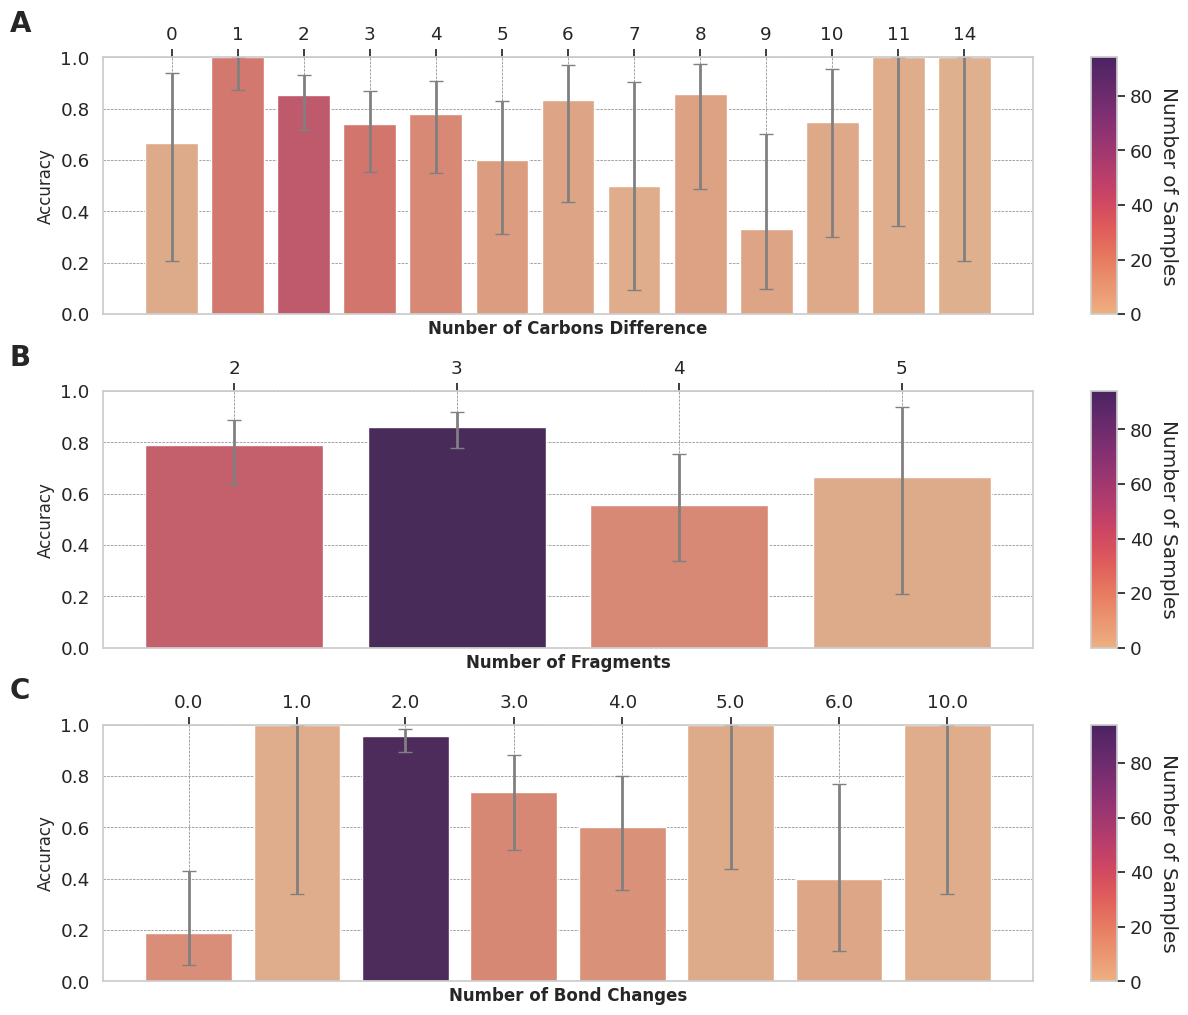

In [269]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

def visualize_accuracy(df, error_bar=True, chart_type='line', error_bar_color='black', same_color_scale=False):
    def calculate_accuracy_and_confidence(df, column):
        group_data = df.groupby(column)['Result'].agg(['sum', 'size'])
        group_data['Accuracy'] = group_data['sum'] / group_data['size']
        
        # Filter out groups with zero accuracy
        group_data = group_data[group_data['Accuracy'] > 0]

        # Calculating Wilson confidence interval
        if error_bar:
            confidence_lower, confidence_upper = proportion_confint(group_data['sum'], group_data['size'], method='wilson')
            group_data['lower'] = group_data['Accuracy'] - confidence_lower
            group_data['upper'] = confidence_upper - group_data['Accuracy']

        return group_data.reset_index()

    # Enhanced color palette
    colors = ['#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256).reversed()

    cmap = plt.get_cmap('flare',256)
    #cmap=cmap.reversed()



    # Calculate accuracy and confidence for each property
    accuracy_carbon = calculate_accuracy_and_confidence(df, 'carbon_difference')
    accuracy_fragment = calculate_accuracy_and_confidence(df, 'fragment_count')
    accuracy_bondchanges = calculate_accuracy_and_confidence(df, 'BondChanges')

    # Normalization for colors
    norm = plt.Normalize(vmin=0, vmax=max(accuracy_carbon['size'].max(), accuracy_fragment['size'].max(), accuracy_bondchanges['size'].max()))

    # Improved font settings for a professional look
    sns.set_context("notebook", font_scale=1.2)
    sns.set_style("whitegrid")

    # Create a figure with 3 subplots
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 12), gridspec_kw={'hspace': 0.3})

    # Plot helper function
    def plot_data(data, x, y, lower, upper, size, subplot_index, xlabel, ecolor, norm):
        ax = axes[subplot_index]
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        colors = [mcolors.to_rgba(cmap(norm(s))) for s in data[size]]

        if chart_type == 'line':
            if error_bar:
                ax.errorbar(data[x], data[y], yerr=[abs(data[lower]), abs(data[upper])], fmt='o', capsize=5, ecolor=ecolor)
            sns.lineplot(data=data, x=x, y=y, marker='o', ax=ax)
        elif chart_type == 'bar':
            barplot = sns.barplot(data=data, x=x, y=y, palette=colors, ax=ax)
            ax.set_ylim(0, 1)
            if error_bar:
                x_positions = [p.get_x() + p.get_width() / 2 for p in barplot.patches]
                ax.errorbar(x_positions, data[y], yerr=[abs(data[lower]), abs(data[upper])], fmt='none', ecolor=ecolor, capsize=5, elinewidth=2)

        # Enhanced layout and grid lines
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
        ax.set_facecolor('white')

        # Enhanced color bar
        cbar = plt.colorbar(sm, ax=ax, label='Number of Samples', pad=0.05, aspect=10)
        cbar.ax.set_ylabel('Number of Samples', rotation=-90, va="bottom")

        # Set x-tick labels to the top
        ax.xaxis.set_label_position('bottom')
        ax.xaxis.tick_top()

        # Set labels
        ax.set_xlabel(xlabel, fontsize=12, fontweight='bold')
        ax.set_ylabel('Accuracy', fontsize=12)

        # Add subplot labels
        ax.text(-0.1, 1.1, chr(65 + subplot_index), transform=ax.transAxes, size=20, weight='bold')

    # Plot data for each subgroup with custom x-labels
    plot_data(accuracy_carbon, 'carbon_difference', 'Accuracy', 'lower', 'upper', 'size', 0, 'Nunber of Carbons Difference', error_bar_color, norm)
    plot_data(accuracy_fragment, 'fragment_count', 'Accuracy', 'lower', 'upper', 'size', 1, 'Number of Fragments', error_bar_color, norm)
    plot_data(accuracy_bondchanges, 'BondChanges', 'Accuracy', 'lower', 'upper', 'size', 2, 'Number of Bond Changes', error_bar_color, norm)

    plt.tight_layout(pad=4.0)
    plt.show()

# Example usage
visualize_accuracy(df, error_bar=True, chart_type='bar', error_bar_color='gray', same_color_scale=False)


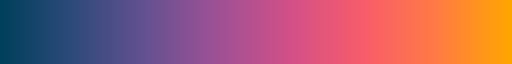

In [250]:
colors = ['#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)
cmap

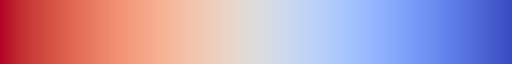

In [256]:
cmap = plt.get_cmap('coolwarm',256)
cmap.reversed()

In [186]:
test1

,R-id,carbon_difference,fragment_count,Index,Result,Unnamed: 4,Unnamed: 5,BondChanges,mcs_carbon_balanced
0,Jaworski_8,3.0,3.0,0.0,True,0,0,5.0,True
1,Jaworski_14,4.0,3.0,1.0,True,0,0,2.0,True
2,Jaworski_31,2.0,2.0,2.0,True,R => fix,0,2.0,True
3,Jaworski_32,2.0,3.0,3.0,True,0,0,2.0,True
4,Jaworski_35,2.0,3.0,4.0,False,0,0,4.0,False
...,...,...,...,...,...,...,...,...,...
151,Jaworski_352,3.0,4.0,151.0,False,CHECK MCS,0,0.0,True
152,Jaworski_385,2.0,4.0,152.0,True,0,0,10.0,True
153,Jaworski_393,2.0,4.0,153.0,True,0,0,10.0,True
154,NaN,NaN,NaN,0.0,False,0,0,0.0,NaN


In [182]:
test2

,R-id,carbon_difference,fragment_count,Index,Result,Unnamed: 4,Unnamed: 5,BondChanges,mcs_carbon_balanced
0,Jaworski_8,3.0,3.0,0.0,True,0,0,5.0,True
1,Jaworski_14,4.0,3.0,1.0,True,0,0,2.0,True
2,Jaworski_31,2.0,2.0,2.0,True,R => fix,0,2.0,True
3,Jaworski_32,2.0,3.0,3.0,True,0,0,2.0,True
5,Jaworski_41,5.0,2.0,5.0,False,0,0,3.0,True
...,...,...,...,...,...,...,...,...,...
149,Jaworski_627,0.0,5.0,149.0,True,CHECK RULE BASED,0,0.0,True
150,Jaworski_331,2.0,3.0,150.0,True,0,0,3.0,True
151,Jaworski_352,3.0,4.0,151.0,False,CHECK MCS,0,0.0,True
152,Jaworski_385,2.0,4.0,152.0,True,0,0,10.0,True


In [161]:
test2

,R-id,carbon_difference,fragment_count,Result,BondChanges,mcs_carbon_balanced
0,Jaworski_8,3,3,True,5.0,True
1,Jaworski_14,4,3,True,2.0,True
2,Jaworski_31,2,2,True,2.0,True
3,Jaworski_32,2,3,True,2.0,True
5,Jaworski_41,5,2,False,3.0,True
...,...,...,...,...,...,...
149,Jaworski_627,0,5,True,NaN,True
150,Jaworski_331,2,3,True,3.0,True
151,Jaworski_352,3,4,False,NaN,True
152,Jaworski_385,2,4,True,10.0,True


In [159]:
test2

,R-id,carbon_difference,fragment_count,Result,BondChanges,mcs_carbon_balanced
0,Jaworski_8,3,3,True,5.0,True
1,Jaworski_14,4,3,True,2.0,True
2,Jaworski_31,2,2,True,2.0,True
3,Jaworski_32,2,3,True,2.0,True
5,Jaworski_41,5,2,False,3.0,True
...,...,...,...,...,...,...
149,Jaworski_627,0,5,True,NaN,True
150,Jaworski_331,2,3,True,3.0,True
151,Jaworski_352,3,4,False,NaN,True
152,Jaworski_385,2,4,True,10.0,True


In [124]:
accuracy_carbon

,carbon_difference,Accuracy
0,0,0.666667
1,1,1.000000
2,2,0.853659
3,3,0.740741
4,4,0.777778
5,5,0.600000
6,6,0.833333
7,7,0.500000
8,8,0.857143
9,9,0.333333
